In [1]:
%%capture
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
from neuronunit.optimisation import make_sim_tests
from neuronunit.optimisation.optimization_management import test_all_objective_test

import numpy as np
from IPython.display import display, HTML
from neuronunit.plottools import plot_score_history1
from neuronunit.optimisation.optimization_management import check_binary_match, dtc_to_rheo
import pandas as pd
from neuronunit.optimisation.optimization_management import TSD
from neuronunit.tests.fi import RheobaseTestP
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plot_defaults = mpl.rcParamsDefault


# Generate Simulated Data with A hodgkin Huxley model 
Then optimize with an adaptive exponential.
Then optimize an adaptive exponential model to fit it.

# Simulated Data 
and select model parameters that are free to vary

In [2]:

params = MODEL_PARAMS["RAW"];
fps = params.keys()#['C','peak_v','b']
model_type="RAW"
sim_tests, OM, target = test_all_objective_test(fps,model_type=model_type)



Random simulated data tests made


# Meta Parameters

In [3]:
MU = 4
NGEN = 14

<Figure size 640x480 with 0 Axes>

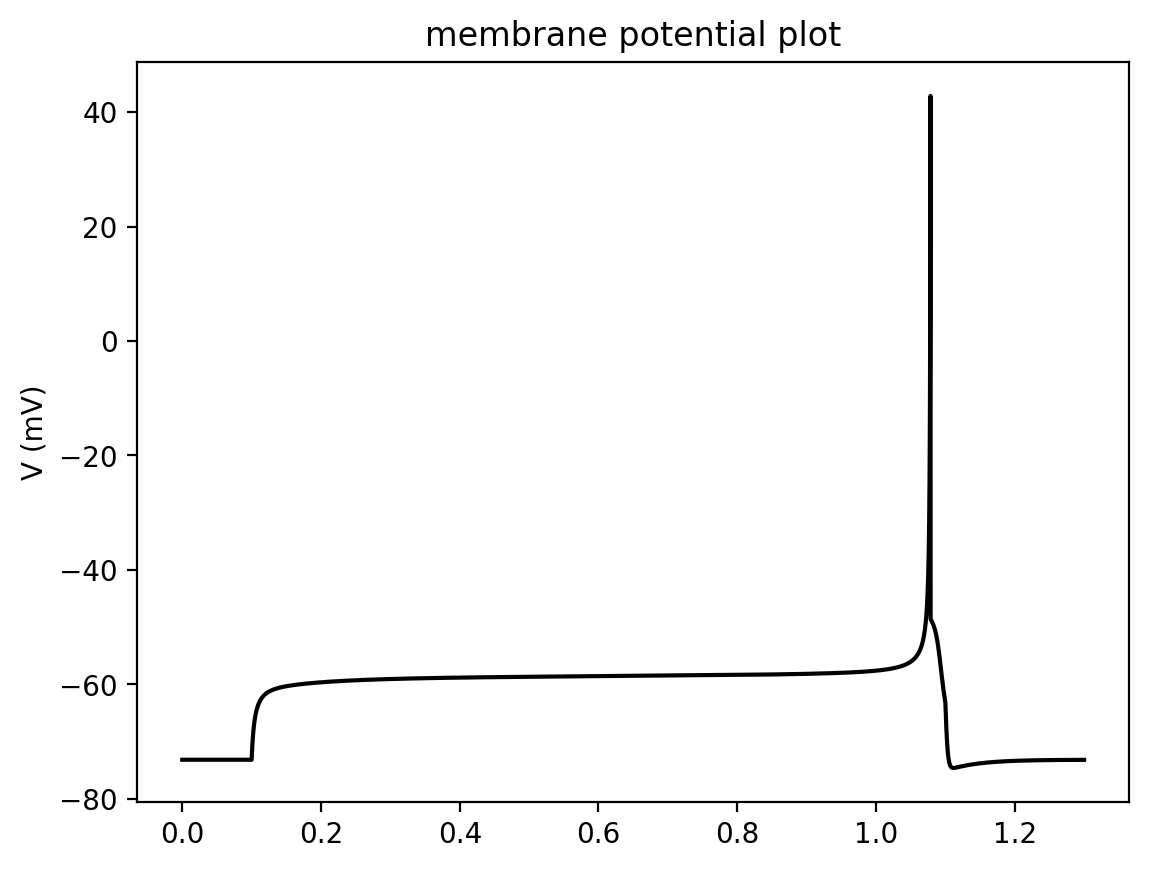

In [4]:
from neuronunit.optimisation.optimization_management import inject_and_plot_model, TSD

_,plt = inject_and_plot_model(target)
plt.show()

In [ ]:
model_type="ADEXP"
params = MODEL_PARAMS[model_type];
fps = params.keys()
results = sim_tests.optimize(backend=model_type,\
        protocol={'allen': False, 'elephant': True},\
            MU=MU,NGEN=NGEN,plot=True,free_parameters=fps)

warning please add whether or not model should be scored on rheobase to protocol


GA Generation Progress:  23%|██▎       | 3/13 [02:02<07:08, 42.84s/it]

In [ ]:
results['pf'][0]
sim_tests.ga_out['td']
OM.td = results['td']
OM.backend = "ADEXP"
results['pf'][0].dtc = OM.update_dtc_pop([results['pf'][0]])[0]
results['hof'][0].dtc = OM.update_dtc_pop([results['hof'][0]])[0]
#results['pf'][0].fitness.values


In [ ]:

opt = results['pf'][0].dtc
hof = results['hof'][0].dtc
opt = results['pf'][0].dtc
opt = dtc_to_rheo(opt)
print(opt.rheobase)

# Analyse Results

In [ ]:

opt.tests = sim_tests
opt.self_evaluate()
opt = opt.get_agreement()
display(opt.agreement)


In [ ]:
# This should be more succint than above.
agreement = opt.get_agreement().agreement

# Look at evolution History

In [ ]:
plt = plot_score_history1(results)
from neuronunit.optimisation.optimization_management import check_binary_match

In [ ]:
model = target.dtc_to_model()
check_binary_match(opt,target,snippets=True)
target = OM.format_test(target)
simulated_data_tests = target.tests

In [ ]:
check_binary_match(opt,target,snippets=False)

In [ ]:
try:
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)
except:
    pass


In [ ]:
display(pd.DataFrame([opt.attrs]))
import copy
temp = {}
for k in opt.attrs.keys():
    temp[k] = target.attrs[k]
display(pd.DataFrame([temp]))

In [ ]:
display(pd.DataFrame([{k.name:v for k,v in opt.SA.items()}]))

What where the values of model parameters that where held constant?


In [ ]:
df0 = opt.dtc_to_model().default_attrs
df1 = target.dtc_to_model().default_attrs
hc = {}

try:
    df0.attrs.pop('dt',None)
    df0.attrs.pop('Iext',None)
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)

except:
    pass

for k,v in df0.items():
    if k not in opt.attrs.keys():
        assert df0[k] == df1[k]
        hc[k] = v        
display("Held constant:")
display(pd.DataFrame([hc]))        

If the Pareto Front encircles the best solution without sampling directly on top of it.
Does piercing the center get us closer to the hall of fame?
Below, plot HOF[0]/PF[0] are they the same model? 

In [ ]:
# check_binary_match(opt,hof,snippets=True)


# Exploring the neighbourhood of 
the Optimal solution is now syntatically easy

## Make ranges to explore:

In [ ]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
a_range = MODEL_PARAMS["RAW"]['a']
grid_a = np.linspace(a_range[0],a_range[1],10)
b_range = MODEL_PARAMS["RAW"]['b']
grid_b = np.linspace(b_range[0],b_range[1],10);

def find_nearest(array, value):
    """
    What if 10 points is too coarse and we miss a minima well?
    We can insert the known optima back into a sequence of grid points just in case
    
    """
    #value = float(value)
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (array[idx], idx)



## Mutate a parameter in a dimension of interest.

In [ ]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['a'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)
for a in tqdm(grid_a):
    # non random mutation
    mutant.attrs['a'] = a
    # Evaluate NU test suite
    mutant.self_evaluate()
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)

In [ ]:
plt.plot(grid_a,collect)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')


The above plot seemed to have two steep wells, of low error about the optima.

It might not be reasonable to expect to sample every such well, as the stochastic nature of the GA is not garunteed to sample small and and focused pockets of error change.

In [ ]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['b'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)

insert_index = find_nearest(grid_b,opt.attrs['b'])[1]
grid_b = list(grid_b)
grid_b.insert(insert_index,opt.attrs['b'])
crheo = []
for b in tqdm(grid_b):
    # non random mutation
    mutant.attrs['b'] = b
    print(mutant.attrs)
    # Evaluate NU test suite
    mutant.self_evaluate()
    print(mutant.rheobase)
    crheo.append(mutant.rheobase)
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)


In [ ]:
plt.plot(grid_b,crheo)


In [ ]:
plt.plot(grid_b,collect)
for_scatter = (opt.attrs['b'],opt_sum)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')
print(grid_b)

In [ ]:
insert_index = find_nearest(grid_b,opt.attrs['b'])
print(insert_index[1])